In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from scipy.spatial.distance import cdist
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns


In [2]:
experiment_name = 'TangentConv_site_3layer_9A_epoch46'
datafolder = Path(f'preds/{experiment_name}')
masif_preds = Path('masif_preds/')
timings = Path('timings/')
raw_data = Path('surface_data/raw/protein_surfaces/01-benchmark_surfaces_npy')
pdb_list = [p.stem[:-5] for p in datafolder.glob('*pred.vtk')]

In [3]:
n_meshpoints = []
n_predpoints = []
meshpoints_mindists = []
predpoints_mindists = []
for pdb_id in tqdm(pdb_list):
    predpoints = np.load(datafolder/(pdb_id+'_predcoords.npy'))
    meshpoints = np.load(datafolder/(pdb_id+'_meshpoints.npy'))
    n_meshpoints.append(meshpoints.shape[0])
    n_predpoints.append(predpoints.shape[0])

    pdists = cdist(meshpoints,predpoints)
    meshpoints_mindists.append(pdists.min(1))
    predpoints_mindists.append(pdists.min(0))

100%|██████████| 348/348 [03:36<00:00,  1.61it/s]


In [4]:
print(np.mean(n_predpoints),np.std(n_predpoints))
print(np.mean(n_meshpoints),np.std(n_meshpoints))

11548.850574712644 1853.1779711119525
6320.732758620689 1028.4567617386515


In [164]:
all_meshpoints_mindists = np.concatenate(meshpoints_mindists)
all_predpoints_mindists = np.concatenate(predpoints_mindists)

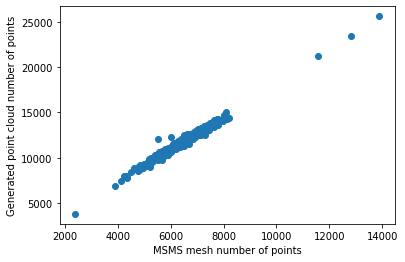

In [165]:
plt.scatter(n_meshpoints,n_predpoints);
plt.xlabel('MSMS mesh number of points');
plt.ylabel('Generated point cloud number of points');
#plt.savefig('figures/pointsperpoint.pdf')

In [166]:
meshpoint_percentile = np.percentile(all_meshpoints_mindists,99)
print(meshpoint_percentile)
predpoint_percentile = np.percentile(all_predpoints_mindists,99)
print(predpoint_percentile)

2.339973475075206
1.3164803592192962


Text(0.5, 0, 'Distance to nearest generated point')

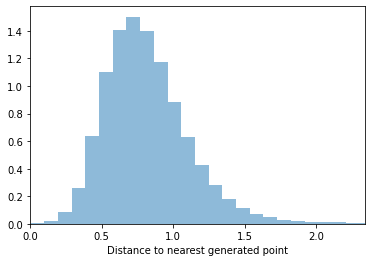

In [167]:
plt.hist(all_meshpoints_mindists,bins=100,alpha=0.5,density=True,label='Min dist to generated pcd');
plt.xlim([0,meshpoint_percentile]);
plt.xlabel('Distance to nearest generated point')

Text(0.5, 0, 'Distance to nearest precomputed mesh point')

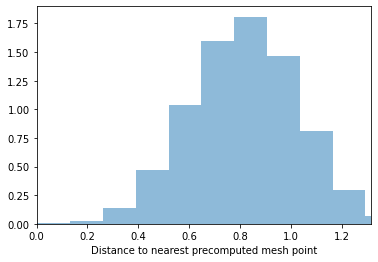

In [168]:
plt.hist(all_predpoints_mindists,bins=400,alpha=0.5,density=True,label='Min dist to precomputed mesh');
plt.xlim([0,predpoint_percentile]);
plt.xlabel('Distance to nearest precomputed mesh point')

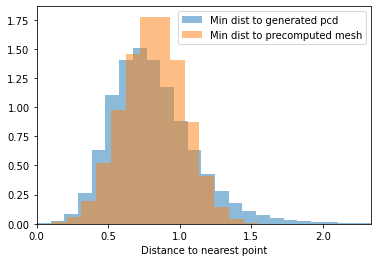

In [169]:
plt.hist(all_meshpoints_mindists,bins=100,alpha=0.5,density=True,label='Min dist to generated pcd');
plt.hist(all_predpoints_mindists,bins=500,alpha=0.5,density=True,label='Min dist to precomputed mesh');
plt.xlim([0,np.max([meshpoint_percentile,predpoint_percentile])]);
plt.xlabel('Distance to nearest point')
plt.legend();
#plt.savefig('figures/nearest_point_dist.pdf')

In [170]:
meshpoints_masks = []
predpoints_masks = []
for pdb_id in tqdm(pdb_list):
    predpoints = np.load(datafolder/(pdb_id+'_predcoords.npy'))
    meshpoints = np.load(datafolder/(pdb_id+'_meshpoints.npy'))

    pdists = cdist(meshpoints,predpoints)
    meshpoints_masks.append(pdists.min(1)<meshpoint_percentile)
    predpoints_masks.append(pdists.min(0)<predpoint_percentile)

100%|██████████| 348/348 [03:41<00:00,  1.57it/s]


In [171]:
predpoints_preds = []
predpoints_labels = []
for i, pdb_id in enumerate(tqdm(pdb_list)):
    predpoints_features = np.load(datafolder/(pdb_id+'_predfeatures.npy'))
    predpoints_features = predpoints_features[predpoints_masks[i]]

    predpoints_preds.append(predpoints_features[:,-2])
    predpoints_labels.append(predpoints_features[:,-1])

100%|██████████| 348/348 [00:00<00:00, 688.02it/s]


In [172]:
roc_auc_score(np.concatenate(predpoints_labels),np.concatenate(predpoints_preds))

0.8650878613609656

In [173]:
fpr_tangent, tpr_tangent, roc_threshold_tangent = roc_curve(np.concatenate(predpoints_labels),np.concatenate(predpoints_preds))

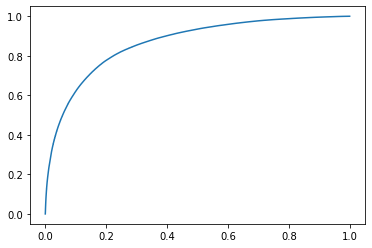

In [174]:
plt.plot(fpr_tangent,tpr_tangent)

In [144]:
conv_times = np.load(timings/f'{experiment_name}_convtime.npy')
print(conv_times.mean(),conv_times.std())

0.036484644654091826 0.00834115514119933


In [175]:
meshpoints_preds = []
meshpoints_labels = []
for i, pdb_id in enumerate(tqdm(pdb_list)):
    mesh_preds = np.load(masif_preds/('pred_'+pdb_id+'.npy'))[0]
    mesh_labels = np.load(datafolder/(pdb_id+'_meshfeatures.npy'))
    mesh_preds = mesh_preds[meshpoints_masks[i]]
    mesh_labels = mesh_labels[meshpoints_masks[i]]

    meshpoints_preds.append(mesh_preds)
    meshpoints_labels.append(mesh_labels)

100%|██████████| 348/348 [00:00<00:00, 580.98it/s]


In [176]:
roc_auc_score(np.concatenate(meshpoints_labels),np.concatenate(meshpoints_preds))

0.8491344631055571

In [177]:
fpr_masif, tpr_masif, roc_threshold_masif = roc_curve(np.concatenate(meshpoints_labels),np.concatenate(meshpoints_preds))

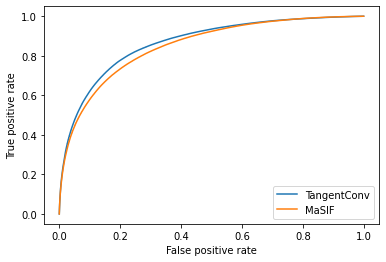

In [178]:
plt.plot(fpr_tangent,tpr_tangent,label='TangentConv')
plt.plot(fpr_masif,tpr_masif,label='MaSIF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right');
#plt.savefig('figures/tang_masif_roc.pdf')

In [179]:
np.save('roc_curves/tangent_site_fpr',fpr_tangent)
np.save('roc_curves/tangent_site_tpr',tpr_tangent)
np.save('roc_curves/masif_site_fpr',fpr_masif)
np.save('roc_curves/masif_site_tpr',tpr_masif)

In [10]:
fpr_tangent_search = np.load('roc_curves/tangent_search_fpr.npy')
tpr_tangent_search = np.load('roc_curves/tangent_search_tpr.npy')
fpr_masif_search = np.load('roc_curves/masif_search_fpr.npy')
tpr_masif_search = np.load('roc_curves/masif_search_tpr.npy')
fpr_tangent = np.load('roc_curves/tangent_site_fpr.npy')
tpr_tangent = np.load('roc_curves/tangent_site_tpr.npy')
fpr_masif = np.load('roc_curves/masif_site_fpr.npy')
tpr_masif = np.load('roc_curves/masif_site_tpr.npy')

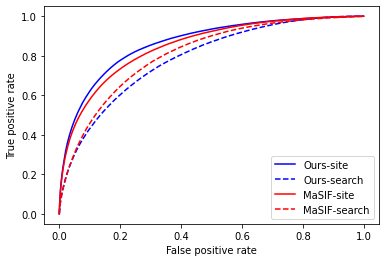

In [11]:
plt.plot(fpr_tangent,tpr_tangent,label='Ours-site',color='blue')
plt.plot(fpr_tangent_search,tpr_tangent_search,label='Ours-search',color='blue',linestyle='dashed')
plt.plot(fpr_masif,tpr_masif,label='MaSIF-site',color='red')
plt.plot(fpr_masif_search,tpr_masif_search,label='MaSIF-search',color='red',linestyle='dashed')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right');
plt.savefig('figures/masif_tangent_comp.pdf')


In [149]:
all_feat_cat = []
for i, pdb_id in enumerate(tqdm(pdb_list)):
    predpoints = np.load(datafolder/(pdb_id+'_predcoords.npy'))
    meshpoints = np.load(datafolder/(pdb_id+'_meshpoints.npy'))
    predpoints = predpoints[predpoints_masks[i]]
    meshpoints = meshpoints[meshpoints_masks[i]]

    pdists = cdist(meshpoints,predpoints)
    pdist = np.argmin(pdists,axis=0)

    predpoints_features = np.load(datafolder/(pdb_id+'_predfeatures.npy'))
    predpoints_features = predpoints_features[predpoints_masks[i]]

    meshpoints_features = np.load(raw_data/(pdb_id+'_features.npy'))
    meshpoints_features = meshpoints_features[meshpoints_masks[i]]

    features_cat = np.concatenate([predpoints_features,meshpoints_features[pdist]],axis=1)
    all_feat_cat.append(features_cat)

100%|██████████| 348/348 [04:57<00:00,  1.17it/s]


In [150]:
features_cat_np = np.concatenate(all_feat_cat,axis=0)

In [151]:
corrmat = np.corrcoef(features_cat_np.T)

In [152]:
meshpoints_features.shape

(6611, 3)

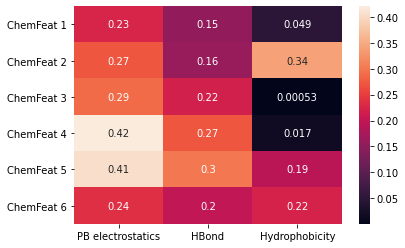

In [153]:
sns.heatmap(np.abs(corrmat[10:16,-3:]),annot=True,xticklabels=['PB electrostatics','HBond','Hydrophobicity'],yticklabels=[f'ChemFeat {i}' for i in range(1,7)])
#plt.savefig('figures/chem_covariance.pdf')

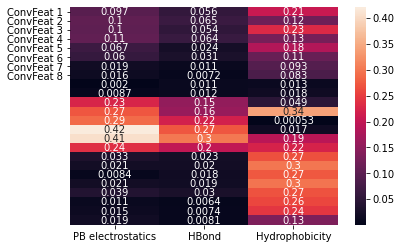

In [155]:
sns.heatmap(np.abs(corrmat[:16+8,-3:]),annot=True,xticklabels=['PB electrostatics','HBond','Hydrophobicity'],yticklabels=[f'ConvFeat {i}' for i in range(1,9)])
#plt.savefig('figures/conv_covariance.pdf')

In [156]:
features_cat_np.shape

(3978810, 29)

(-5.0, 5.0)

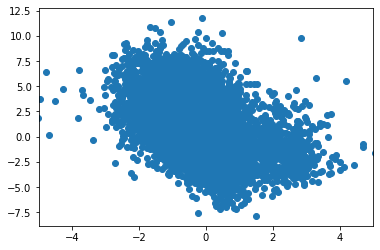

In [160]:
features_sample = np.random.choice(len(features_cat_np),10000,replace=False)
features_sample = features_cat_np[features_sample]
plt.scatter(features_sample[:,-3],features_sample[:,13])
plt.xlim([-5,5])

(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 7.000e+00, 4.700e+01,
        6.884e+03, 3.005e+03, 4.900e+01, 5.000e+00]),
 array([-20.2865    , -17.367167  , -14.447831  , -11.528496  ,
         -8.60916   ,  -5.6898255 ,  -2.7704904 ,   0.14884463,
          3.0681796 ,   5.987515  ,   8.90685   ], dtype=float32),
 <a list of 10 Patch objects>)

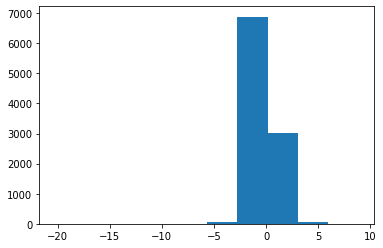

In [159]:
plt.hist(features_sample[:,-3])

In [2]:
performance = [0.865,0.686,0.849,0.804,0.835]
times = [231,211,1050,162,173]
time_errors = [0,0,0,51,71]
labels = ['TangentConv 3 layers', 'DGCNN 3 layers','MaSIF 3 layers', 'PointNet++ 1layer','TangentConv 1 layer']
fig = go.Figure()
for i in range(len(times)):
    fig.add_trace(go.Scatter(
            x=[times[i]],
            y=[performance[i]],
            mode='markers',
            name=labels[i],
            error_x=dict(
                type='data',
                symmetric=True,
                array=[time_errors[i]])))


fig.update_layout(
    xaxis_title='Execution time [ms]',
    yaxis_title='Site identification ROC-AUC',
    legend_title="Models",
)
fig.show()
fig.write_image('figures/site_time_perf.pdf')



In [96]:
fig = go.Figure()
for i in range(len(times)):
    fig.add_trace(go.Scatter(
            x=[times[i]],
            y=[performance[i]],
            mode='markers',
            name=labels[i],
            error_x=dict(
                type='data',
                symmetric=True,
                array=[time_errors[i]])))


fig.update_layout(
    xaxis_title='Execution time [ms]',
    yaxis_title='Site identification ROC-AUC',
    legend_title="Models",
)
fig.show()

In [91]:
list(time_errors[i])

0